# **Loading the dataset and libraries**

In [1]:
import numpy as np 
import pandas as pd 
import os
import json
from pandas.io.json import json_normalize
import ast
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.mplot3d import Axes3D
import ast
import re
import yaml
import json
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import eli5
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import warnings  
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
sam_sub = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
print( "train dataset:", train.shape,"\n","test dataset: ",test.shape,"\n","sample_submission dataset:", sam_sub .shape)

train dataset: (3000, 23) 
 test dataset:  (4398, 22) 
 sample_submission dataset: (4398, 2)


## **Attribute Explanation**

**ID**- Integer unique id of each movie

**Belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

**Budget**:Budget of a movie in dollars. 0 values mean unknown.

**Genres** : Contains all the Genres Name & TMDB Id in JSON Format

**Homepage** - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie.

**Imdb_id** - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

**Original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

**Original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English.

**Overview** - Brief description of the movie.

**Popularity** - Popularity of the movie in float.

**Poster_path** - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/

**Production_companies** - All production company name and TMDB id in JSON format of a movie.

**Production_countries** - Two digit code and full name of the production company in JSON format.

**Release_date** - Release date of a movie in mm/dd/yy format.

**Runtime** - Total runtime of a movie in minutes (Integer).

**Spoken_languages** - Two digit code and full name of the spoken language.

**Status** - Is the movie released or rumored?

**Tagline** - Tagline of a movie

**Title** - English title of a movie

**Keywords** - TMDB Id and name of all the keywords in JSON format.

**Cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

**Crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

**Revenue** - Total revenue earned by a movie in dollars.

# **Just for fun: top revenue movies**

In [3]:
# All time winner in the dataset
train.loc[train['revenue'].idxmax(),['title','revenue','release_date']]

title           The Avengers
revenue           1519557910
release_date         4/25/12
Name: 1126, dtype: object

## **Top 5 Revenue Movies in the Dataset**


* 
<table><tr>
<td> <img src="https://is2-ssl.mzstatic.com/image/thumb/Video118/v4/04/6a/b4/046ab45e-6099-3e1a-ccef-7b3f8b07f057/contsched.sumsaanu.lsr/268x0w.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://images-na.ssl-images-amazon.com/images/I/81ClciXon2L._SY445_.jpg"  alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/en/f/ff/Avengers_Age_of_Ultron_poster.jpg"  alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/en/d/d6/Beauty_and_the_Beast_2017_poster.jpg"  alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://images-na.ssl-images-amazon.com/images/I/51BG6ovCJpL.jpg"  alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

In [4]:
# Top 20 revenue movie in the dataset

train.sort_values(by='revenue', ascending=False).head(20)[['title','revenue','release_date']]

,title,revenue,release_date
1126,The Avengers,1519557910,4/25/12
1761,Furious 7,1506249360,4/1/15
2770,Avengers: Age of Ultron,1405403694,4/22/15
684,Beauty and the Beast,1262886337,3/16/17
2322,Transformers: Dark of the Moon,1123746996,6/28/11
906,The Dark Knight Rises,1084939099,7/16/12
2135,Pirates of the Caribbean: On Stranger Tides,1045713802,5/14/11
2562,Finding Dory,1028570889,6/16/16
881,Alice in Wonderland,1025491110,3/3/10
734,Zootopia,1023784195,2/11/16


# **Data Pre-processing & EDA**

In [5]:
#Let's take a look at the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

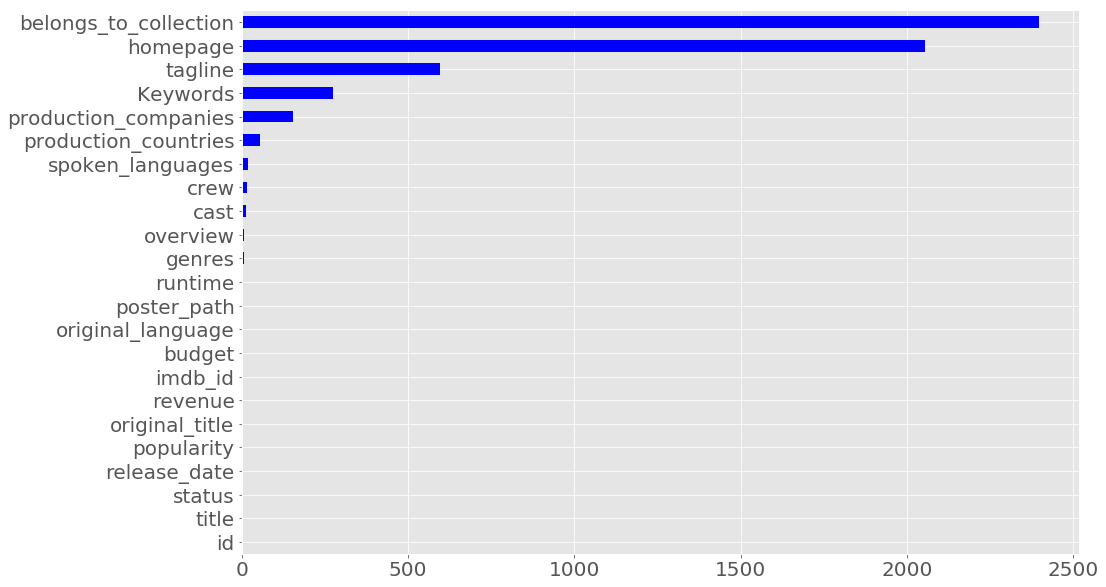

In [7]:
#Counting NA in dataset

fig = plt.figure(figsize=(15, 10))
train.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='Blue', fontsize=20)


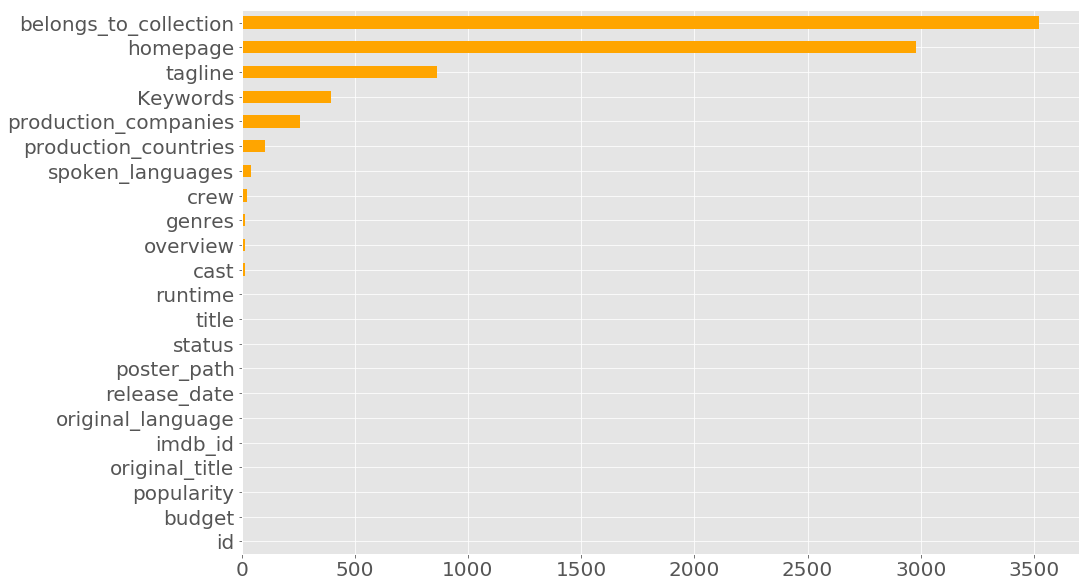

In [8]:
fig = plt.figure(figsize=(15, 10))
test.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='Orange', fontsize=20)

In [10]:
## From this function, you can convert release_date column from the character data type to the datetime data type

def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

train=date_features(train)
test=date_features(test)

train['release_year'].head(10)

0    2015
1    2004
2    2014
3    2012
4    2009
5    1987
6    2012
7    2004
8    1996
9    2003
Name: release_year, dtype: int64

There are some records that release above 2019 (coming from the future?!).<br> For these records, it probably makes sense to change the century (ex. 2065 --> 1965, we are not ready to accept you, 2065!!) 

In [11]:
train['release_year'].iloc[np.where(train['release_year']> 2019)][:10]

39     2065
41     2067
51     2065
61     2056
68     2062
109    2066
140    2068
144    2067
172    2066
187    2028
Name: release_year, dtype: int64

In [12]:
train['release_year']=np.where(train['release_year']> 2019, train['release_year']-100, train['release_year'])
test['release_year']=np.where(test['release_year']> 2019, test['release_year']-100, test['release_year'])

In [13]:
## Filling NA values with mode of each column

fillna_column = {'release_year':'mode','release_month':'mode',
                'release_day':'mode'}

for k,v in fillna_column.items():
    if v == 'mode':
        fill = train[k].mode()[0]
    else:
        fill = v
    print(k, ': ', fill)
    train[k].fillna(value = fill, inplace = True)
    test[k].fillna(value = fill, inplace = True)

release_year :  2013
release_month :  9
release_day :  1


In [14]:
# Putting revised year, month, and day together 

def year_month_together(df):
    year = df["release_year"].astype(int).copy().astype(str)
    month=df['release_month'].astype(int).copy().astype(str)
    day=df['release_day'].astype(int).copy().astype(str) 
    df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df 

train=year_month_together(train)
test=year_month_together(test)

train['release_date'].head(10)

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
5   1987-08-06
6   2012-08-30
7   2004-01-15
8   1996-02-16
9   2003-04-16
Name: release_date, dtype: datetime64[ns]

From this interactive plot, we can tell that the majority of movies in the dataset released from 00s - 10s.<br>I am wondering the **sample bias issue** in the dataset. Since there are not many movies released from 90s, it is hard to compare movies from 90s and 00s-10s. 


In [15]:
# Counting movie number by release date

d1 = train['release_date'].value_counts().sort_index()
d2 = test['release_date'].value_counts().sort_index()
data = [go.Histogram(x=d1.index, y=d1.values, name='train'), go.Histogram(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of release_date",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

Text(0, 0.5, 'Revenue (100 million dollars)')

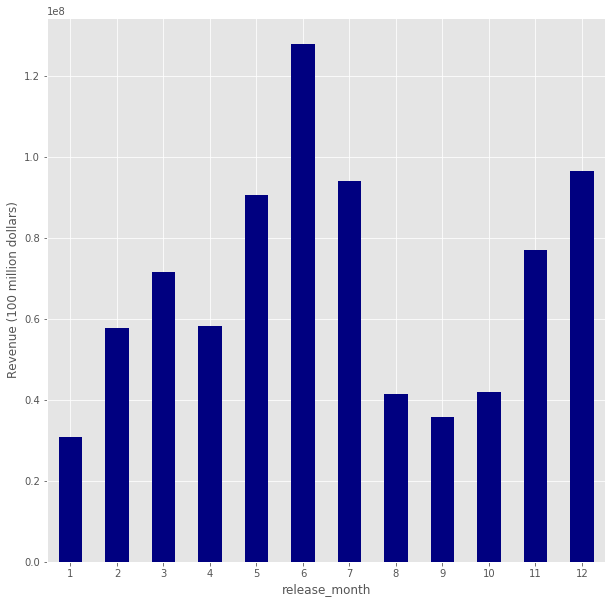

In [16]:
# Average revenue by month

fig = plt.figure(figsize=(10,10))

train.groupby('release_month').agg('mean')['revenue'].plot(kind='bar',color='navy',rot=0)
plt.ylabel('Revenue (100 million dollars)')

The popularity over years plot implies that the mean popularity of movies is increasing over year. Year 2017 has a high mean popularity in the train dataset

Text(0.5, 1.0, 'Mean Popularity Over Years')

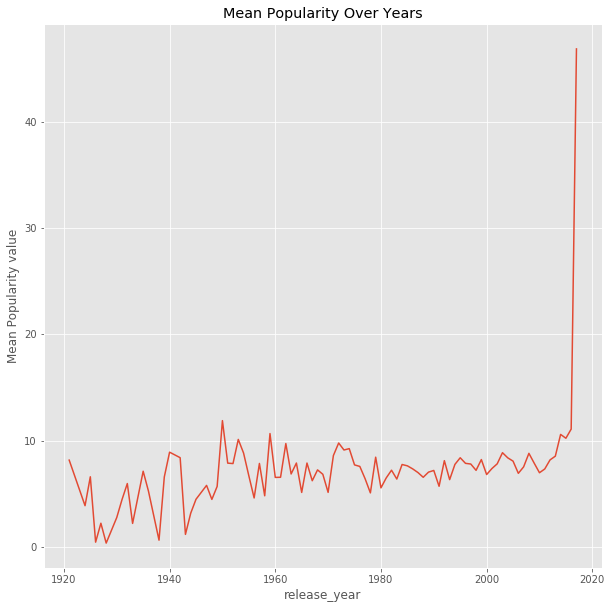

In [17]:
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(10, 10))
release_year_mean_data['popularity'].plot(kind='line')
plt.ylabel('Mean Popularity value')
plt.title('Mean Popularity Over Years')

We can also use 3D plot to invetigate the relationship between budget, revenue, and popularity of movies. <br>
  From the 3D plot and the corrplot, we can see that they have somewhat strong positive correlations to each other.

Text(0.5, 0, 'Popularity of the Movie')

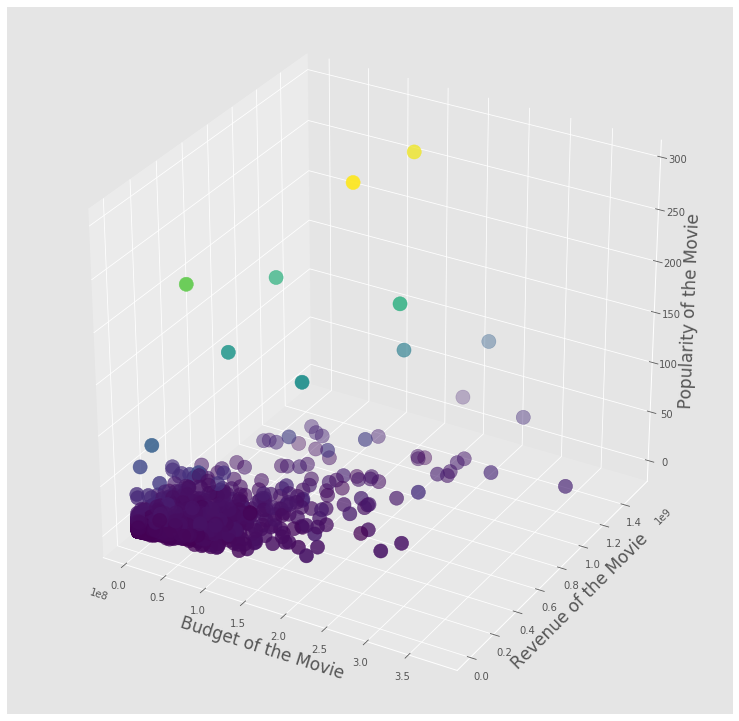

In [18]:
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,projection = '3d')

# Data for three-dimensional scattered points
zdata =train.popularity
xdata =train.budget
ydata = train.revenue
ax.scatter3D(xdata, ydata, zdata, c=zdata, s = 200)
ax.set_xlabel('Budget of the Movie',fontsize=17)
ax.set_ylabel('Revenue of the Movie',fontsize=17)
ax.set_zlabel('Popularity of the Movie',fontsize=17)


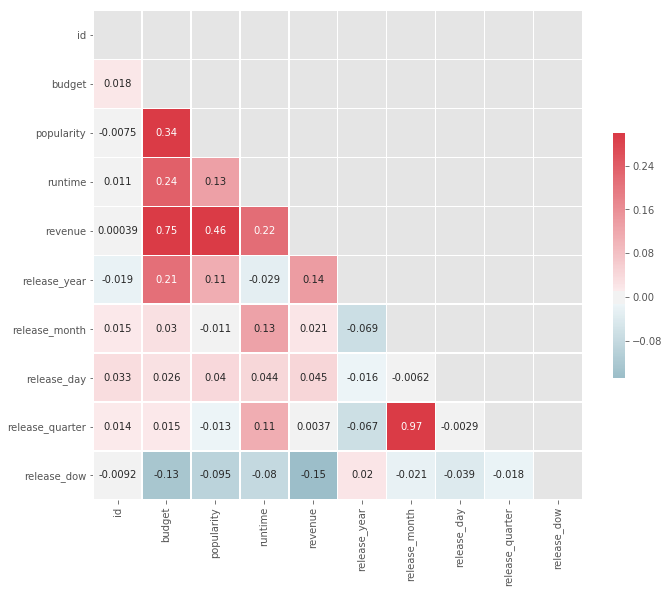

In [19]:
# Creating correlation matrix 

corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})